# estimation of spiral core size
Tim Tyree<br>
8.27.2023

In [2]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt

import skimage as sk
from skimage import measure, filters

from numba import njit, jit, vectorize
from PIL import Image
import imageio
# import cv2 as cv

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
# width = 512
# height = 512
# channel_no = 3

# #load the libraries
from lib import *
# from lib.measure._find_tips_pbc_cy import lookup_segments
# from lib.measure._find_tips_kernel import *
# from lib.measure._find_tips_kernel_cy import find_intersections
#use cuda via numba
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
from numba.typed import List
# from lib.contours_to_tips import *
import shutil
from lib.measure.comp_tips_safely import get_comp_tips
from lib.viewer.DomainPlot import SaveTipsAndColoredContours

%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# define module

# load initial conditions containing spiral tips for FK

In [16]:
#LR
input_dir=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-in/ic019.33.npz"

In [24]:
#FK
input_dir=f"{nb_dir}/Data/initial-conditions-suite-1/ic-in/ic_200x200.121.33.npz"

In [25]:
assert os.path.exists(input_dir)

## generate snippet with greater than one period of motion for FK

In [21]:
get_time_step_fk,one_step_fk=recall_flow_map_fk(nb_dir=nb_dir,diffCoef=0.0005,width=200,height=200,dsdpixel=0.025)

param_fn is param_set_8.json.


In [22]:
get_time_step_fk(texture, out)

## compute the Hilbert transform everywhere

## compute the phase defect everywhere

# load initial conditions containing spiral tips for LR

In [30]:
# ic_fn=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-out/ic008.33.npz"
ic_fn=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-in/ic008.33.npz"
t=0

txt=load_buffer(ic_fn)
ds=5.
frameno=1
# txt=load_buffer(txt_fn)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]
V_threshold=-40
dt=0.1 #supports really long termination time...
diffCoef=0.001#0.0005
Cm=1.0
# comp_dict_topo_full_color=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=V_threshold)
# get_one_step at this dt
__, arr39, one_step = get_one_step_explicit_synchronous_splitting(
    nb_dir=nb_dir,dt=dt,width=width,height=height,ds=ds,diffCoef=diffCoef,Cm=Cm)
# comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=V_threshold,level2=0)

In [31]:
#estimated run time <2 min
DT=4 #ms
nsteps_per_DT=int(DT/dt)
#comp img_prev example
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
#integrate to t=100 milliseconds
while t<100:
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    t+=dt
img_prev=inVc[...,0].copy()
for n in range(nsteps_per_DT):
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    t+=dt
txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt).copy()
img=inVc[...,0].copy();#dimgdt=dVcdt[...,0]

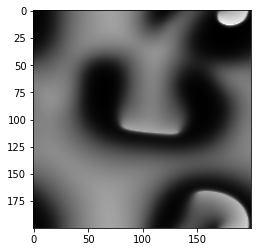

In [34]:
#Q: can I estimate the diameter of a spiral core using dVdt instead of its Hilbert transform/the analytic signal?
plt.imshow(img,cmap='gray')

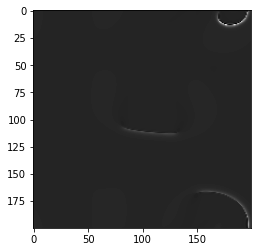

In [36]:
dVdt=dVcdt[...,0].copy()
# .shape
plt.imshow(dVdt,cmap='gray')

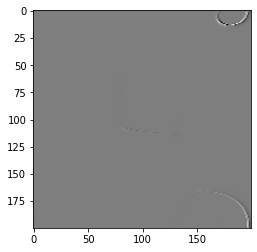

In [57]:
img_dVdtd0=np.gradient(dVdt,axis=0)
img_dVdtd1=np.gradient(dVdt,axis=1)
# plt.imshow(img_dVdtd0,cmap='gray')
plt.imshow(img_dVdtd1,cmap='gray')

In [64]:
#TODO: estimate the phase everywhere
# img_vphase = np.arctan2(img_dVdtd1,img_dVdtd0)
img_vphase = np.arctan2(img_dVdtd0,img_dVdtd1)

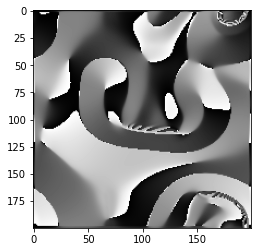

In [95]:
plt.imshow(img_vphase,cmap='gray')
# plt.imshow(img_ph,cmap='gray_r')


In [66]:
np.max(img_vphase),np.min(img_vphase)

(3.1415153, -3.1415205)

In [84]:
#estimate the phase coherence everywhere
image=img_vphase
img_ph=np.zeros_like(image)
for i in range(width-1):
    for j in range(height-1):
        phase =np.exp(1j*image[i,j+1])
        phase+=np.exp(1j*image[i,j-1])
        phase+=np.exp(1j*image[i+1,j])
        phase+=np.exp(1j*image[i-1,j])
        ph=np.abs(phase)/4.
        img_ph[i,j]=ph

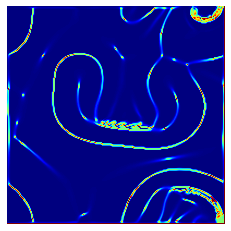

In [94]:
# plt.imshow(img_ph,cmap='gray_r')
plt.imshow(img_ph,cmap='jet_r')
plt.axis('off')
plt.show()

In [79]:
#TODO: generate phase map from xy derivative
# plt.quiver(img_dVdtd0,img_dVdtd1)
np.sqrt(phase.conj()*phase)/4.

(0.5523389813907644+0j)

In [76]:
0.66**2/4

0.10890000000000001

In [41]:
import skimage

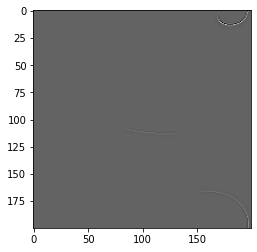

In [46]:
dVdt_grad=skimage.filters.laplace(dVdt, ksize=3, mask=None)
plt.imshow(dVdt_grad,cmap='gray')

In [47]:
dVdt_grad

array([[  1.5222828 ,  -0.5641108 ,  -0.3034606 , ...,  62.717316  ,
         -6.494223  ,  -8.693199  ],
       [  1.1988367 ,  -0.5319286 ,  -0.2943341 , ...,  43.638424  ,
         -6.812715  ,  -8.723932  ],
       [  0.84170306,  -0.4705703 ,  -0.24789767, ...,  -8.636595  ,
        -13.404076  ,  -8.16816   ],
       ...,
       [  1.8801223 ,  -0.8694825 ,  -0.4935738 , ..., 137.46866   ,
        -28.881077  , -15.332462  ],
       [  1.6776623 ,  -0.8786013 ,  -0.47958446, ..., 126.66633   ,
        -26.83943   , -14.2006235 ],
       [  1.4096373 ,  -0.8993889 ,  -0.49188486, ...,  87.84785   ,
        -20.39306   , -12.751667  ]], dtype=float32)

## generate snippet with greater than one period of motion for LR

## compute the Hilbert transform everywhere for LR

# estimate the diameter of spiral core
- HINT: import the image to ImageJ. measure the width of the spiral core. b.o.e. estimate diameter of spiral core. repeat for other full model. go to bed.

# (bonus) select phase defect regions with a threshold
- (bonus) plot ^this threshold on the xaxis with spiral core size on the yaxis

# (bonus) compute HDBSCAN to select spiral core pixels

# (bonus) compute the diameter of spiral core

# (bonus) repeat for many spiral cores

## (bonus) generate a histogram of apparent spiral core diameters

## (bonus) add ^that histogram as a supplementary figure